In [1]:
# lib's base 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lib's para séries temporais
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels import api as sm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. análise exploratória

In [2]:
st_variaveis = pd.read_csv('../dados/outputs/st_variaveis.csv')
st_variaveis.set_index('DATA', inplace=True)
st_variaveis.head()

,TICKER,EMPRESA,QTD_NEGOCIOS,QTD_PAPEIS_NEGOCIADOS,VOL_TOTAL_NEGOCIADO,IBOVESPA_GOOGLE,IBOV_TWITTER,IBOVESPA_TWITTER,BOVA11_TWITTER
DATA,,,,,,,,,
2021-01-04,BOVA11,ISHARES BOVA,41278.0,8493210.0,9.730709e+08,69,83,298,6
2021-01-05,BOVA11,ISHARES BOVA,2390.0,9620560.0,1.094933e+09,77,128,277,7
2021-01-06,BOVA11,ISHARES BOVA,666.0,9094230.0,1.049862e+09,75,104,287,7
2021-01-07,BOVA11,ISHARES BOVA,50022.0,9250540.0,1.081833e+09,79,182,375,14
2021-01-08,BOVA11,ISHARES BOVA,42698.0,11955320.0,1.427557e+09,72,224,381,18


### 1.1. análise gráfica de tendência e sazonalidade

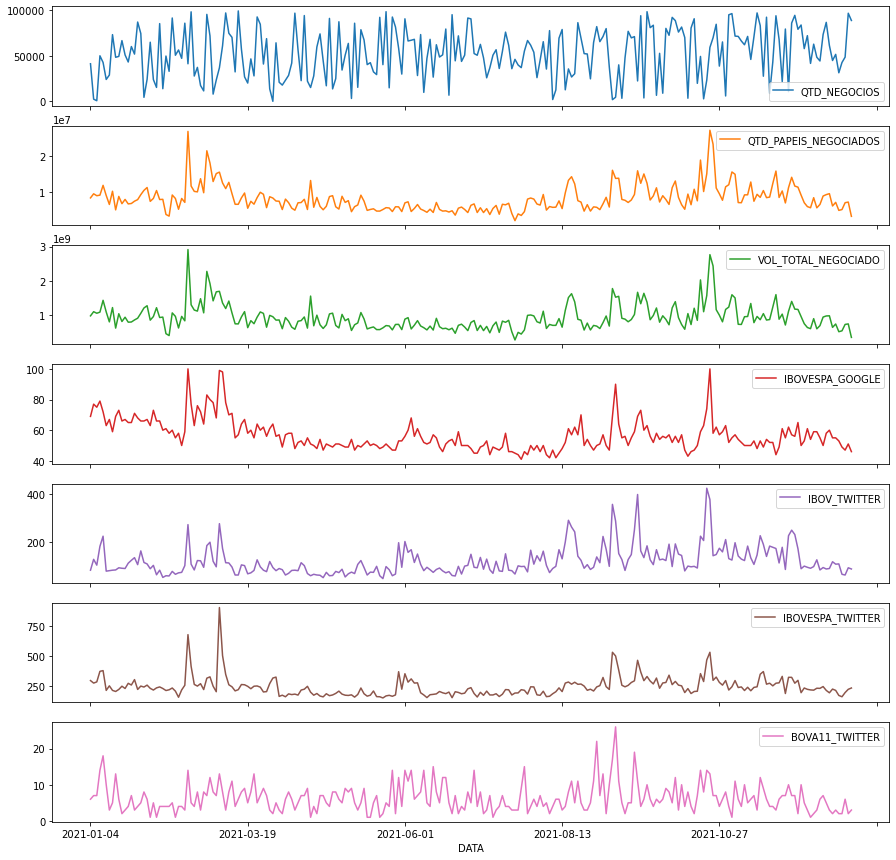

In [3]:
st_variaveis.plot(subplots = True, figsize = (15, 15))
plt.show()

- pela análise gráfica, não há tendência e sazonalidade em todas as séries

###  1.2. análise de correlação

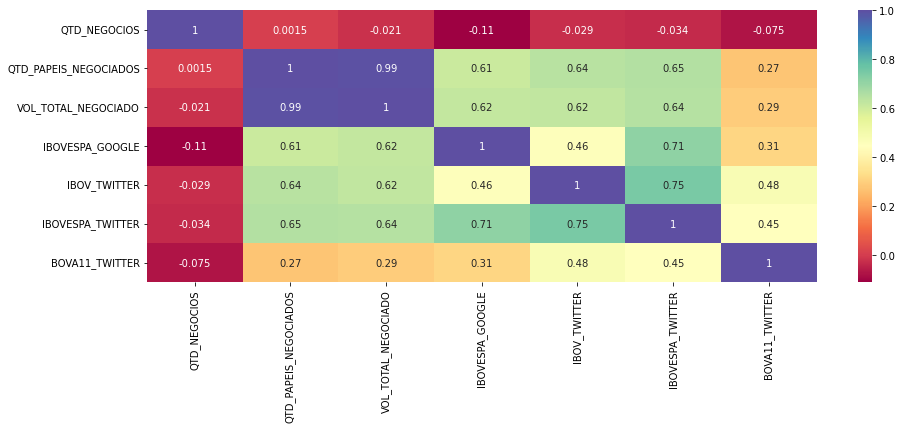

In [4]:
plt.figure(figsize = (15, 5))

corr_matrix = st_variaveis.corr()
#corr_matrix.to_csv('../../../unicamp/mono_01/imagens/corr_matrix.csv')

sns.heatmap(corr_matrix, cmap = 'Spectral', annot = True)
plt.show()

- volume total negociado e quantidade de papéis negociados são extremamente correlacionados, portanto, ambos podem ser a variável dependente
- nenhuma das potenciais variáveis independentes são fortemente correlacionadas (>= 0.8), portanto, todas serão mantidas

In [5]:
X = st_variaveis[['IBOVESPA_GOOGLE', 'IBOV_TWITTER', 'IBOVESPA_TWITTER', 'BOVA11_TWITTER']]
y = st_variaveis['VOL_TOTAL_NEGOCIADO']

### 1.3. análise de outliers

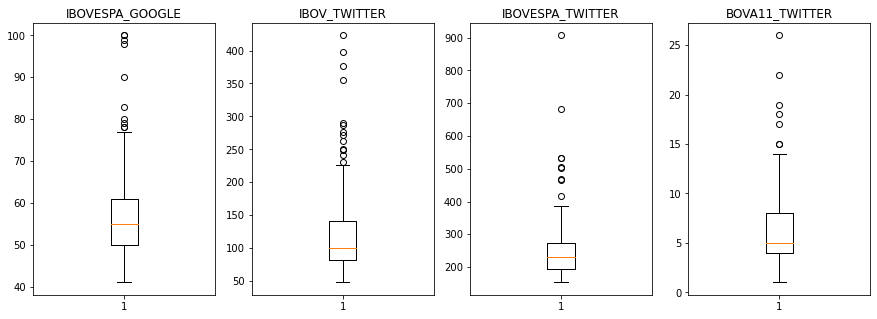

In [6]:
fig, axs = plt.subplots(nrows = 1, ncols = len(X.columns), figsize = (15,5))

for i, col in enumerate(X.columns):
    axs[i].boxplot(X[col])
    axs[i].set_title(col)

plt.show()

In [7]:
st_variaveis = pd.concat([y, X], axis=1)
st_variaveis.rename(columns = {0:'VOL_TOTAL_NEGOCIADO'}, inplace = True)

## 2. teste de raiz unitária

### teste Augmented Dickey Fuller (ADF)

- The null hypothesis of the ADF is that there is a unit root
- If the pvalue is above a critical size, then we cannot reject that there is a unit root

se o valor da estatística < valor crítico a um nível de significância de 5% e o p-value < 0.05, rejeita-se a hipótese nula, isto é, a série não possui raiz unitária e, portanto, é estacionária.

In [8]:
def transf_estac(df):
    """
    Verifica se as séries são originalmente estacionárias
    Aplica diferenciação até que as séries se tornem estacionárias
    Retorna um dataframe com os resultados e um dataframe com as séries após as diferenciações
    """
    
    # cria lista e df para armazenar os resultados e as saídas das séries estacionárias
    resultados = []
    st_variaveis_estac = pd.DataFrame()
    
    # para cada coluna no df, aplica o teste ADF
    for col in df.columns:
        d = 0
        series = df[col]
        adf = adfuller(series)
        # se passar no teste, é estacionária a priori, senão, não é estacionária
        if adf[0] < adf[4]['5%']:
            estac = 'SIM'
        else:
            estac = 'NÃO'
        # enquanto a série não for estacionária, aplica a diferenciação
        while adf[0] > adf[4]['5%']:
            # soma 1 a quantidade de diferenciações a cada diferenciação
            d += 1
            series = series.diff().dropna()
            adf = adfuller(series)
        # preenche df's de resultado e das séries estacionárias
        resultados.append({'VARIÁVEL': col + '_ESTAC', 'ESTACIONÁRIA A PRIORI': estac, 'DIFERENCIAÇÕES': d, 'LAG': adf[2], 'VALOR DO TESTE': adf[0], 'VALOR CRÍTICO 5%': adf[4]['5%'], 'P-VALUE': adf[1]})
        st_variaveis_estac[col+ '_ESTAC'] = series
        st_variaveis_estac.dropna(inplace = True)
    df_resultados = pd.DataFrame(resultados)
    # retorna ambos os df's
    return df_resultados, st_variaveis_estac

# aplica a função
df_resultados, st_variaveis_estac = transf_estac(st_variaveis)

df_resultados

,VARIÁVEL,ESTACIONÁRIA A PRIORI,DIFERENCIAÇÕES,LAG,VALOR DO TESTE,VALOR CRÍTICO 5%,P-VALUE
0,VOL_TOTAL_NEGOCIADO_ESTAC,SIM,0,1,-6.322349,-2.873609,3.044338e-08
1,IBOVESPA_GOOGLE_ESTAC,SIM,0,2,-4.270201,-2.873659,5.000605e-04
2,IBOV_TWITTER_ESTAC,SIM,0,2,-5.513391,-2.873659,1.949282e-06
3,IBOVESPA_TWITTER_ESTAC,NÃO,1,8,-10.345649,-2.874026,2.615349e-18
4,BOVA11_TWITTER_ESTAC,SIM,0,5,-4.523420,-2.873814,1.783418e-04


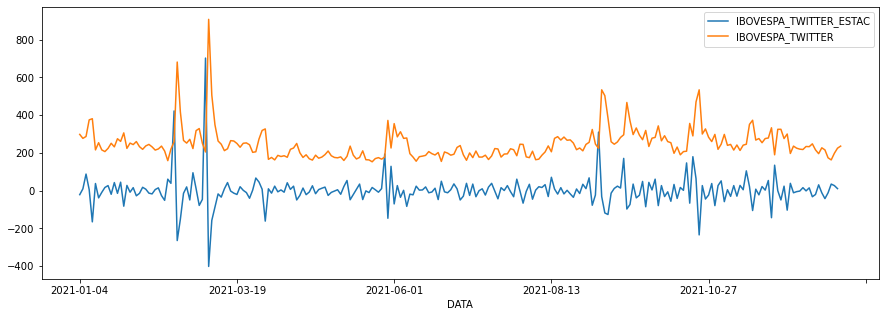

In [9]:
# comparativo da série estacionária com a série não estacionária

st_variaveis_estac['IBOVESPA_TWITTER_ESTAC'].plot(figsize = (15, 5))
st_variaveis['IBOVESPA_TWITTER'].plot(figsize = (15, 5))

plt.legend(loc = 'best')
plt.show()

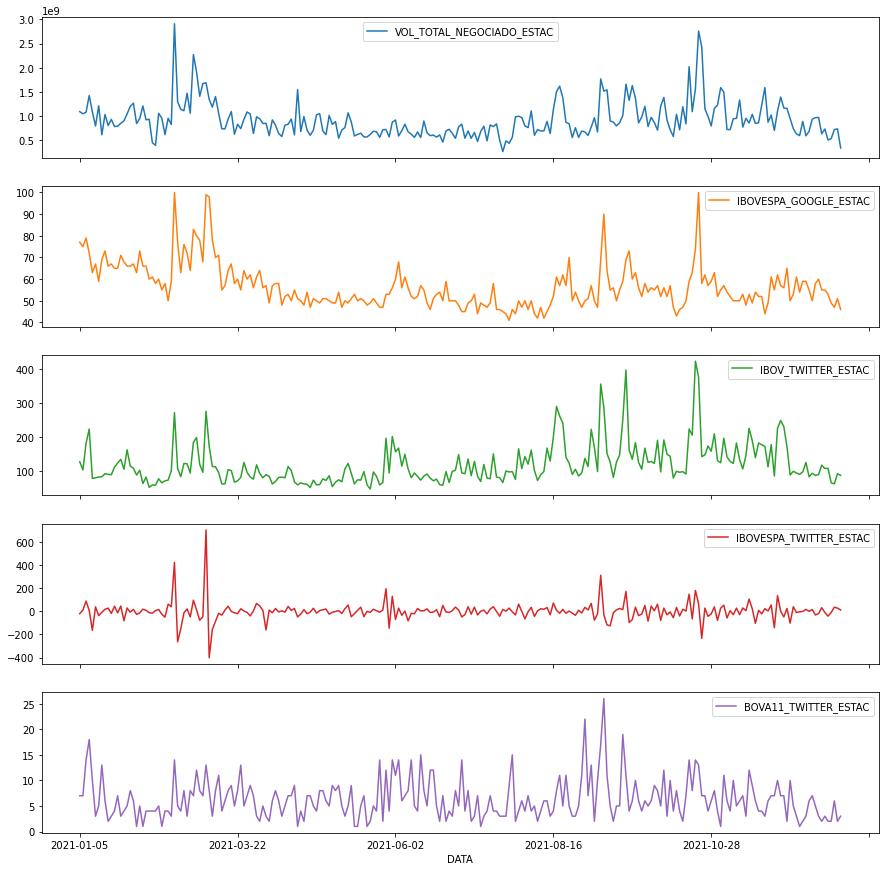

In [10]:
st_variaveis_estac.plot(subplots = True, figsize = (15, 15))
plt.show()

* com todas as séries estacionárias, é possível aplicar o teste de causalidade de granger

## 3. teste de causalidade

### teste de causalidade de Granger

- The Null hypothesis for grangercausalitytests is that the time series x2 (independente), does NOT Granger cause the time series x1 (dependente)
- We reject the null hypothesis if the pvalues are below a desired size of the test

se o p-value < 0.05, rejeita-se a hipótese nula, isto é, a série x2 granger causa a série x1

In [11]:
# cria lista para armazenar os resultados
lista_resultados = []

# aplica o teste para cada coluna no df, desde que não seja a coluna com a variável dependente
for col in st_variaveis_estac.columns:
    y = st_variaveis_estac['VOL_TOTAL_NEGOCIADO_ESTAC']
    if col != 'VOL_TOTAL_NEGOCIADO_ESTAC':
        x = st_variaveis_estac[col]
        resultados = grangercausalitytests(pd.concat([y, x], axis = 1), maxlag = 3, verbose = False)
        # computa o resultado do teste e o p-value para cada lag definido acima
        for lag in resultados.keys():
            f_value = resultados[lag][0]["params_ftest"][0]
            p_value = resultados[lag][0]["params_ftest"][1]
            # se o p-value é menor que 0.05, a variável independente granger causa a variável dependente
            if p_value < 0.05:
                causalidade = 'SIM'
            else:
                causalidade = 'NÃO'
            # preenche df de resultado
            lista_resultados.append([col, 'VOL_TOTAL_NEGOCIADO_ESTAC', lag, f_value, p_value, causalidade])

# cria df a partir da lista de resultados
df_resultados = pd.DataFrame(lista_resultados, columns = ['VARIÁVEL INDEPENDENTE', 'VARIÁVEL DEPENDENTE', 'LAG', 'F-VALUE', 'P-VALUE', 'CAUSALIDADE'])

df_resultados

,VARIÁVEL INDEPENDENTE,VARIÁVEL DEPENDENTE,LAG,F-VALUE,P-VALUE,CAUSALIDADE
0,IBOVESPA_GOOGLE_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,1,11.142618,0.000979,Sim
1,IBOVESPA_GOOGLE_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,2,5.415850,0.005018,Sim
2,IBOVESPA_GOOGLE_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,3,3.554821,0.015111,Sim
3,IBOV_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,1,18.188540,0.000029,Sim
4,IBOV_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,2,9.454961,0.000112,Sim
5,IBOV_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,3,6.416615,0.000342,Sim
6,IBOVESPA_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,1,0.097123,0.755583,Não
7,IBOVESPA_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,2,1.056817,0.349206,Não
8,IBOVESPA_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,3,1.036824,0.376993,Não
9,BOVA11_TWITTER_ESTAC,VOL_TOTAL_NEGOCIADO_ESTAC,1,3.013694,0.083858,Não


## 4. Conclusão

- as variáveis não estão fortemente correlacionadas, portanto, neste critério, todas foram mantidas
- a variável IBOVESPA_TWITTER foi a única que não passou no teste de estacionariedade e, portanto, precisou de transformação por diferenciação
- no teste de causalidade, somente as séries das variáveis IBOVESPA_GOOGLE_ESTAC e IBOV_TWITTER_ESTAC granger causam a série da variável dependente, portanto, somente estas seguirão para a modelagem

In [12]:
st_variaveis_estac[['VOL_TOTAL_NEGOCIADO_ESTAC', 'IBOVESPA_GOOGLE_ESTAC', 'IBOV_TWITTER_ESTAC']].to_csv('../dados/outputs/st_variaveis_modelagem.csv')